# Foundations-2025 — PCA (from scratch)

**Purpose:** Implement Principal Component Analysis (PCA) from first principles using NumPy only. This Kaggle-ready notebook explains the math intuition, shows two implementations (covariance eigendecomposition and SVD), visualizes projections, computes explained variance, performs reconstruction, and demonstrates whitening.

**Usage:** Run cells sequentially in a Kaggle kernel. All libraries used (NumPy, scikit-learn, matplotlib) are available by default on Kaggle.


In [1]:
# Environment check (optional)
import sys, platform, numpy as np, sklearn, matplotlib
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__, 'scikit-learn:', sklearn.__version__, 'matplotlib:', matplotlib.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 1.26.4 scikit-learn: 1.2.2 matplotlib: 3.7.2


## Imports & helper functions
Minimal imports and small helper utilities for PCA experiments.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
import matplotlib.pyplot as plt

np.random.seed(0)

def center_data(X):
    """Center columns of X (zero mean). Returns centered X and mean vector."""
    mu = X.mean(axis=0)
    return X - mu, mu

def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])


## PCA — Math Intuition

PCA finds orthogonal directions (principal components) that maximize variance of the data. Two common ways to compute PCA:

1. **Covariance eigendecomposition**: compute covariance matrix `C = (1/n) X^T X` (with centered X) and find eigenvectors/values of `C`.
2. **Singular Value Decomposition (SVD)**: compute `X = U S V^T`. Columns of `V` (rows of `V^T`) are principal directions. SVD is numerically stable and preferred in practice.

Key formulas:
- Projected data on first k PCs: `Z = X_centered @ V_k`
- Reconstruction: `X_hat = Z @ V_k.T + mu`
- Explained variance by eigenvalues `lambda_i`: `lambda_i / sum(lambda_j)`

We'll implement both methods and verify they produce the same projections.


## 1) Load dataset (Iris) and center it

In [3]:
data = load_iris()
X = data.data.astype(float)
y = data.target
feature_names = data.feature_names

print('X shape:', X.shape)
Xc, mu = center_data(X)
print('Mean (first 4):', mu)


X shape: (150, 4)
Mean (first 4): [5.84333333 3.05733333 3.758      1.19933333]


## 2) PCA via covariance matrix (eigendecomposition)
Compute covariance matrix and perform eigen-decomposition. Sort eigenvalues descending.

In [4]:
# Covariance matrix (using unbiased estimator: divide by n-1)
cov = np.cov(Xc, rowvar=False)  # shape (d,d)
eigvals, eigvecs = np.linalg.eigh(cov)  # eigh for symmetric matrices
# sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print('Eigenvalues:', eigvals)
print('Top-2 eigenvectors shape:', eigvecs[:, :2].shape)


Eigenvalues: [4.22824171 0.24267075 0.0782095  0.02383509]
Top-2 eigenvectors shape: (4, 2)


### Project onto first 2 principal components and visualize

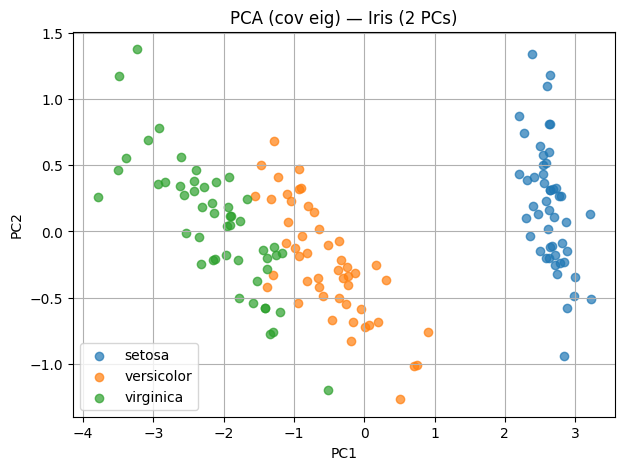

In [5]:
PC2 = Xc @ eigvecs[:, :2]  # projection
plt.figure(figsize=(7,5))
for cls in np.unique(y):
    plt.scatter(PC2[y==cls,0], PC2[y==cls,1], label=data.target_names[cls], alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (cov eig) — Iris (2 PCs)'); plt.legend(); plt.grid(True); plt.show()


## 3) PCA via SVD
Compute SVD of centered data and compare the principal directions and projections to the covariance method.

Dot product between PC1 (cov) and PC1 (svd): 1.0000000000000002
Dot product between PC2 (cov) and PC2 (svd): 1.0000000000000004


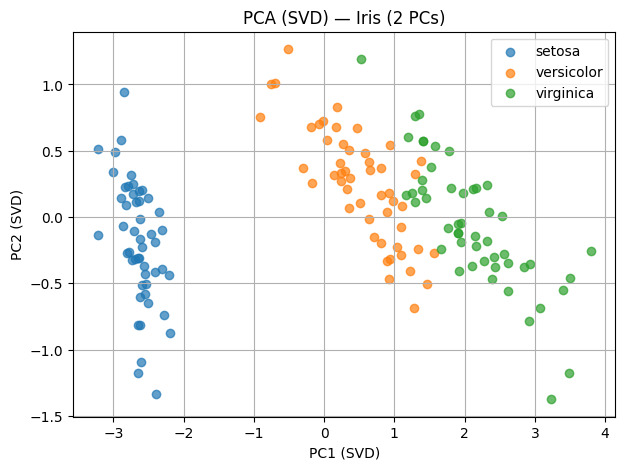

In [6]:
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
# Vt rows are principal directions
V = Vt.T
PC2_svd = Xc @ V[:, :2]

# Compare first two PCs from both methods (up to sign)
print('Dot product between PC1 (cov) and PC1 (svd):', np.abs(np.dot(eigvecs[:,0], V[:,0])))
print('Dot product between PC2 (cov) and PC2 (svd):', np.abs(np.dot(eigvecs[:,1], V[:,1])))

# Plot SVD projection (should match)
plt.figure(figsize=(7,5))
for cls in np.unique(y):
    plt.scatter(PC2_svd[y==cls,0], PC2_svd[y==cls,1], label=data.target_names[cls], alpha=0.7)
plt.xlabel('PC1 (SVD)'); plt.ylabel('PC2 (SVD)'); plt.title('PCA (SVD) — Iris (2 PCs)'); plt.legend(); plt.grid(True); plt.show()


## 4) Explained variance
Compute explained variance ratio from eigenvalues and cumulative explained variance.

In [7]:
explained = eigvals / eigvals.sum()
print('Explained variance ratio (all PCs):', np.round(explained, 4))
print('Cumulative (first 2):', explained[:2].sum())


Explained variance ratio (all PCs): [0.9246 0.0531 0.0171 0.0052]
Cumulative (first 2): 0.977685206318795


## 5) Reconstruction from k components
Project to k components then reconstruct to original space and compute reconstruction error (MSE).

In [8]:
def reconstruct_from_pcs(Xc, V, k, mu):
    Z = Xc @ V[:, :k]
    X_hat = Z @ V[:, :k].T + mu
    return X_hat

for k in [1,2,3,4]:
    Xhat = reconstruct_from_pcs(Xc, eigvecs, k, mu)
    mse = np.mean((X - Xhat)**2)
    print(f'k={k}, reconstruction MSE: {mse:.6f}')


k=1, reconstruction MSE: 0.085604
k=2, reconstruction MSE: 0.025341
k=3, reconstruction MSE: 0.005919
k=4, reconstruction MSE: 0.000000


## 6) PCA Whitening (sphering)
Whitening rescales components to have unit variance. This can be done using SVD components and singular values.

In [9]:
# PCA whitening using SVD components (epsilon for numerical stability)
eps = 1e-5
W_whiten = V[:, :2] @ np.diag(1.0 / (S[:2] + eps))  # shape (d, k)
Z_whiten = Xc @ W_whiten  # whitened data (k dims)
print('Whitened shape:', Z_whiten.shape)
print('Whitened cov (approx):\n', np.cov(Z_whiten, rowvar=False))


Whitened shape: (150, 2)
Whitened cov (approx):
 [[ 6.71140405e-03 -1.96959422e-18]
 [-1.96959422e-18  6.71138707e-03]]


## 7) Sanity check with scikit-learn PCA
Compare our implementation with scikit-learn's PCA (explained variance and components).

In [10]:
skpca = SKPCA(n_components=4, svd_solver='full', random_state=0)
skpca.fit(X)
print('sklearn explained variance ratio:', np.round(skpca.explained_variance_ratio_,4))
print('Our explained variance ratio:', np.round(explained,4))
# components may differ by sign
print('First sklearn component dot our first component (abs):', np.abs(np.dot(skpca.components_[0], eigvecs[:,0])))


sklearn explained variance ratio: [0.9246 0.0531 0.0171 0.0052]
Our explained variance ratio: [0.9246 0.0531 0.0171 0.0052]
First sklearn component dot our first component (abs): 0.9999999999999998


## 8) High-dimensional synthetic example — visualize variance drop-off
Create a synthetic high-dim dataset with a low-rank signal + noise to demonstrate PCA capturing signal.

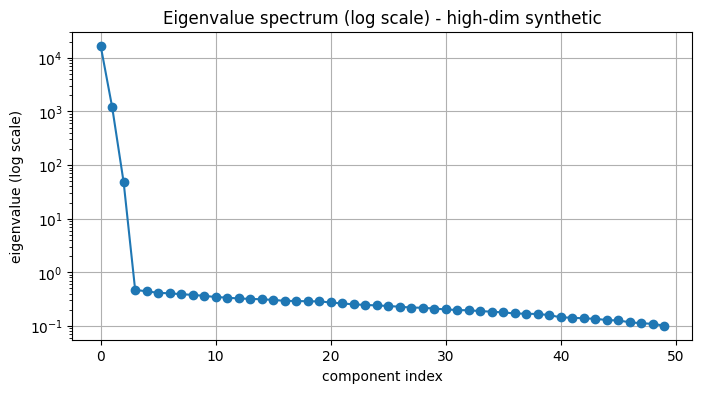

In [11]:
# Synthetic low-rank data (n_samples x n_features)
n_samples = 300
n_features = 50
rank = 3
# generate low-rank signal: X = U S Vt + noise
U = np.random.randn(n_samples, rank)
V = np.random.randn(n_features, rank)
Ssig = np.array([20.0, 5.0, 1.0])  # strong signal in first three directions
X_sig = U * Ssig  @ V.T  # broadcast: (n_samples, rank) * (rank,) -> (n_samples, rank) @ V.T
# simpler: construct via dot
X_sig = (np.random.randn(n_samples, rank) @ np.diag(Ssig) @ np.random.randn(rank, n_features))
noise = 0.5 * np.random.randn(n_samples, n_features)
X_hd = X_sig + noise
X_hd_c, mu_hd = center_data(X_hd)

# SVD and eigvals
U_hd, S_hd, Vt_hd = np.linalg.svd(X_hd_c, full_matrices=False)
eigvals_hd = (S_hd**2) / (n_samples - 1)
plt.figure(figsize=(8,4))
plt.semilogy(eigvals_hd, marker='o')
plt.title('Eigenvalue spectrum (log scale) - high-dim synthetic')
plt.xlabel('component index'); plt.ylabel('eigenvalue (log scale)'); plt.grid(True); plt.show()


## Notes & extensions
- For large datasets, use randomized SVD or incremental PCA.  
- PCA is sensitive to scaling; standardize features if they have different units.  
- PCA is linear — for nonlinear structure consider Kernel PCA or manifold methods (t-SNE, UMAP).  

**Extensions you can add:** incremental PCA, randomized SVD, kernel PCA, and real-data examples (images, word embeddings).
